plt.stairs(list(df_hist_h['count']))

# Financial Data Analysis

We load the necessary modules and libraries. 

In [14]:
import pandas as pd
import pytz
import numpy as np
import matplotlib.text as text
import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta, time, date
from tiingo import TiingoClient


The following pulls the financial data from [Tiingo](https://www.tiingo.com/).
Because of the free plan limitation, to request stock prices at minute resolution requries breaking the request into month-sized pieces. 
The data is then saved locally to a csv file for future use and sharing. 

In [15]:

# client = TiingoClient()
# hist = []
# hist.append(client.get_ticker_price("AGL",startDate='2022-01-01',endDate='2022-01-31',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-02-01',endDate='2022-02-28',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-03-01',endDate='2022-03-31',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-04-01',endDate='2022-04-30',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-05-01',endDate='2022-05-31',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-06-01',endDate='2022-06-30',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-07-01',endDate='2022-07-31',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-08-01',endDate='2022-08-31',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-09-01',endDate='2022-09-30',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-10-01',endDate='2022-10-31',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-11-01',endDate='2022-11-30',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2022-12-01',endDate='2022-12-31',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2023-01-01',endDate='2023-01-31',frequency='1Min'))
# hist.append(client.get_ticker_price("AGL",startDate='2023-02-01',endDate='2023-02-13',frequency='1Min'))
# for i, mon in enumerate(hist): 
#     hist[i] = pd.DataFrame.from_dict(mon,orient='columns')
# hist = pd.concat(hist,axis=0,ignore_index=True)
# hist.to_csv('../data/history.csv',sep=',')

We read the locally-stored historical data. 

In [16]:
df = pd.read_csv('../data/history.csv',index_col=0,parse_dates=['date'])

The time information in the data file is a datetime stamp in UTC. 
We add derived columns to the data to seperate date from time and present the information in New York (US/Eastern) time. 

In [17]:
eastern = pytz.timezone('US/Eastern')
df['day'] = df['date'].map(lambda x: date(x.year,x.month,x.day))
df['time'] = df['date'].map(lambda x: time(x.astimezone(eastern).hour,x.astimezone(eastern).minute))

We create two new tables. The first has the daily high and what time that high was occured. The second is analgously constructed for the daily low. 
For each of these tables we then subdivide the market day into 30 minute intervals, and see how the daily extrema are distributed into those 30 
minute bins. 

In [18]:
#Make a list of the highs for each day
vals_h = df.loc[df.groupby('day')['high'].idxmax()].sort_index().copy()
#Filter for the last three months
vals_h = vals_h[vals_h['day'] >= date(2022,11,1)]
#Calculate the bin in wich that day's high falls
vals_h['period'] = vals_h['time'].map(lambda x: (60*x.hour+x.minute) // 30)
#Tally how many days fall into each bin
plot_vals_h = vals_h.groupby(['period'])['period'].count().reset_index(name='count')

#Make a list of the lows for each day
vals_l = df.loc[df.groupby('day')['low'].idxmin()].sort_index().copy()
#Filter for the last three months
vals_l = vals_l[vals_l['day'] >= date(2022,11,1)]
#Calculate the bin in wich that day's low falls
vals_l['period'] = vals_l['time'].map(lambda x: (60*x.hour+x.minute) // 30)
#Tally how many days fall into each bin
plot_vals_l = vals_l.groupby(['period'])['period'].count().reset_index(name='count')


To have more control over the final prsentation, we create some ancillary tables which 
enumerates all our possible intervals and labels for those intervals. 
The default histogram functions are slightly awkward to use when there are intervals in which have no extrema, 
and when we have already calcualted our "bins."

In [19]:
periods = list(range(19,34))
bins = []
for i in periods:
    l_bound = time(i //2,30*(i % 2)).isoformat(timespec='minutes')
    r_bound = time((i+1) //2,30*((i+1) % 2)).isoformat(timespec='minutes')
    bins.append(l_bound+"-"+r_bound)
df_hist = pd.DataFrame({'period': periods,'bin': bins})

We create tables of results whose columns will be plotted, along with our chart ticks and labels. 

In [20]:
df_hist_h = (df_hist.copy()).merge(plot_vals_h,on='period',how='left').fillna(0)
df_hist_h['count'] = df_hist_h['count'].astype('Int64')

df_hist_l = (df_hist.copy()).merge(plot_vals_l,on='period',how='left').fillna(0)
df_hist_l['count'] = df_hist_l['count'].astype('Int64')

locs = list(df_hist_h['period']).copy()
labels = list(df_hist_h['bin']).copy()
for i , x in enumerate(labels):
    labels[i] = text.Text(locs[i],0,labels[i])
labels
edges=[18.5]+[x+0.5 for x in locs]

Our histogram of daily highs.

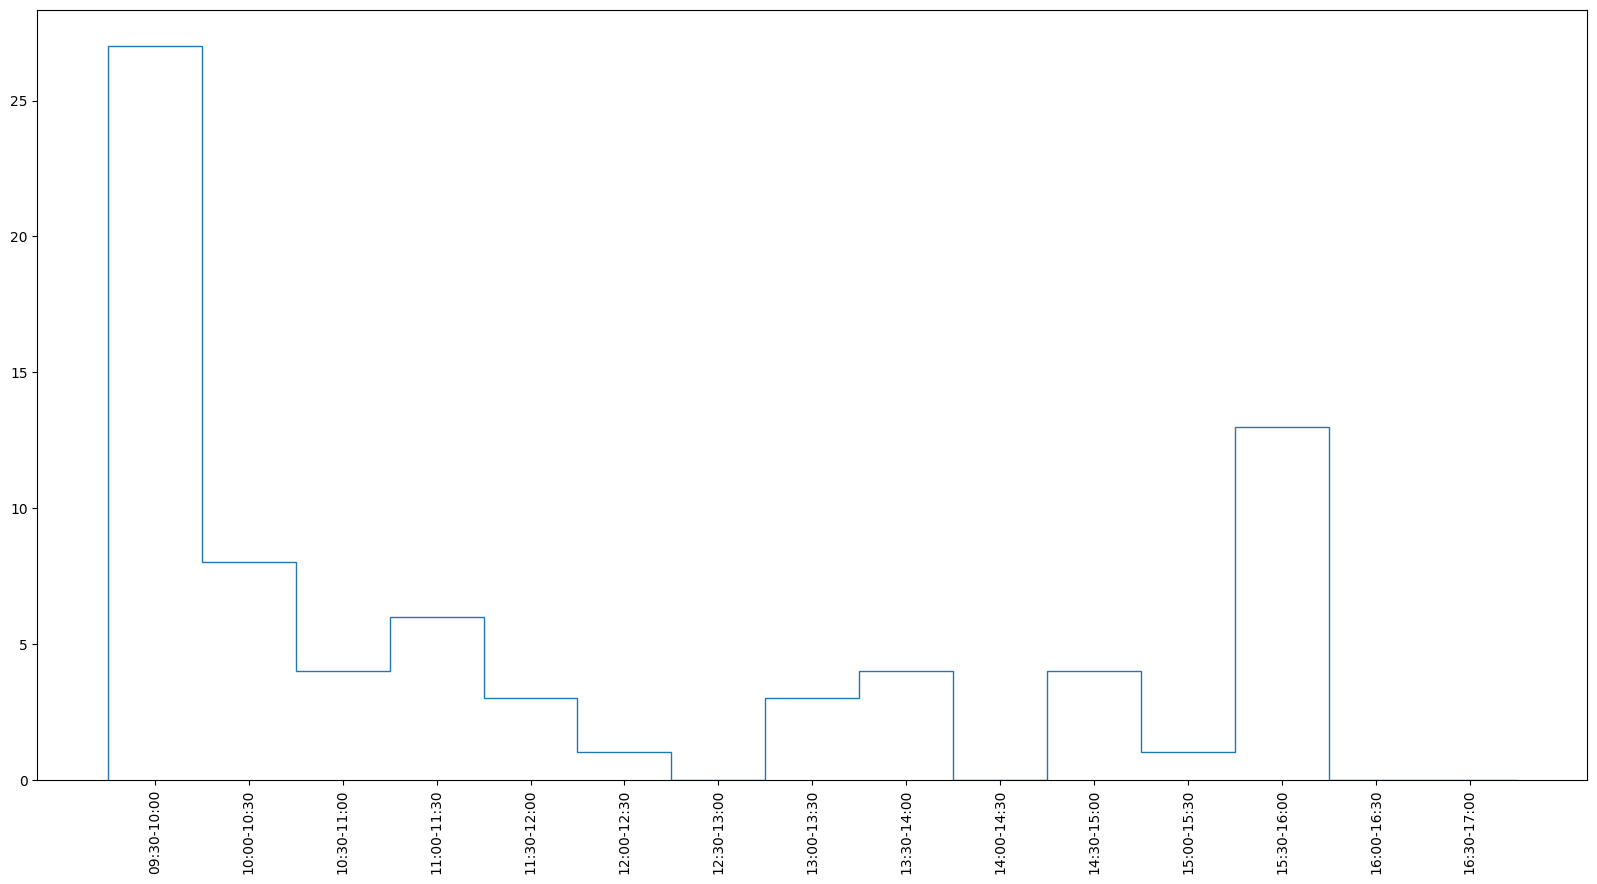

In [21]:
plt.figure(figsize=(20,10))
plt.xticks(locs,labels)
plt.xticks(rotation=90)
plt.stairs(list(df_hist_h['count']),edges=edges)

Our histogram of daily lows.

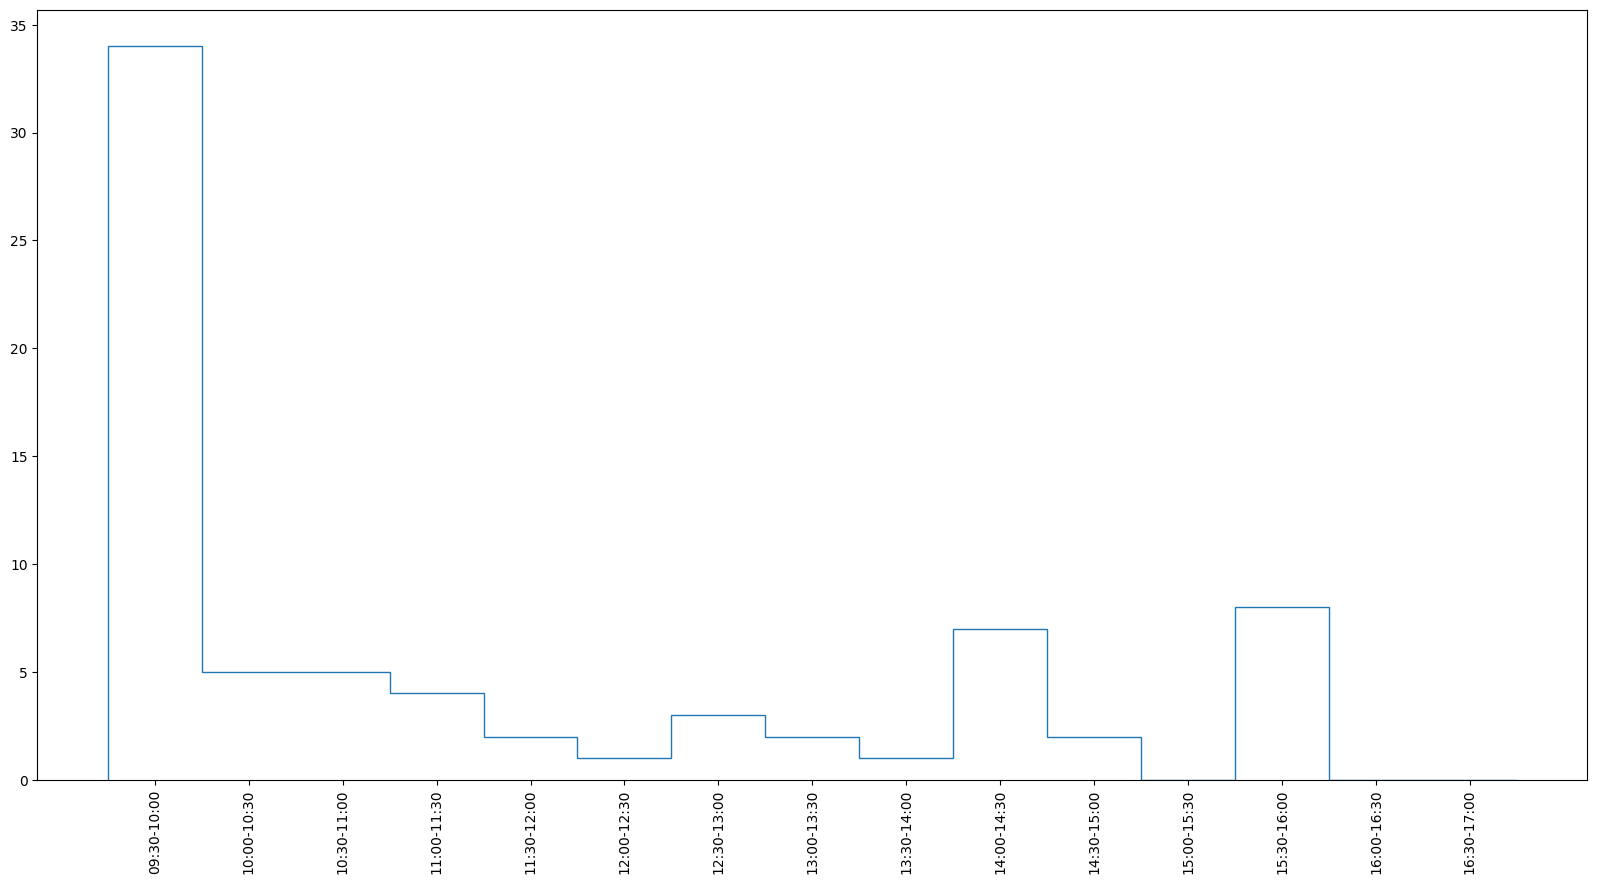

In [22]:
plt.figure(figsize=(20,10))
plt.xticks(locs,labels)
plt.xticks(rotation=90)
plt.stairs(list(df_hist_l['count']),edges=edges)

The plurality of daily extrema occurs in the first thrirty minutes of trading, probably reflecting 
after-market movements. 
There has been work done examining intra-day volatility. 
I found this Bloomberg Report([https://assets.bbhub.io/professional/sites/10/intraday_volatility-3.pdf]) specifically about the subject. 
Their analysis is a bit more sophisticated, but what's interesting is our historgrams of extrema are qualatatively similar to their plots
of intraday volatility. 
This isn't suprising; our time horizon is so short we should expect volatility to dominate any underlying rate-of-return.
Intervals of heightened intraday volatility are precisely when you would expect extrema to be achieved. 
But if the above is all true, everything we did for AGL should be applicable for other assets. 
So I reran the above analysis on Vanguard's [Small-Cap Grroth Fund: VBK](https://investor.vanguard.com/investment-products/etfs/profile/vbk).

In [23]:
# client = TiingoClient()
# hist = []
# hist.append(client.get_ticker_price("VBK",startDate='2022-01-01',endDate='2022-01-31',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-02-01',endDate='2022-02-28',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-03-01',endDate='2022-03-31',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-04-01',endDate='2022-04-30',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-05-01',endDate='2022-05-31',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-06-01',endDate='2022-06-30',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-07-01',endDate='2022-07-31',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-08-01',endDate='2022-08-31',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-09-01',endDate='2022-09-30',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-10-01',endDate='2022-10-31',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-11-01',endDate='2022-11-30',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2022-12-01',endDate='2022-12-31',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2023-01-01',endDate='2023-01-31',frequency='1Min'))
# hist.append(client.get_ticker_price("VBK",startDate='2023-02-01',endDate='2023-02-13',frequency='1Min'))
# for i, mon in enumerate(hist): 
#     hist[i] = pd.DataFrame.from_dict(mon,orient='columns')
# hist = pd.concat(hist,axis=0,ignore_index=True)
# hist.to_csv('../data/VBK.csv',sep=',')

In [24]:
df = pd.read_csv('../data/VBK.csv',index_col=0,parse_dates=['date'])

eastern = pytz.timezone('US/Eastern')
df['day'] = df['date'].map(lambda x: date(x.year,x.month,x.day))
df['time'] = df['date'].map(lambda x: time(x.astimezone(eastern).hour,x.astimezone(eastern).minute))

#Make a list of the highs for each day
vals_h = df.loc[df.groupby('day')['high'].idxmax()].sort_index().copy()
#Filter for the last three months
vals_h = vals_h[vals_h['day'] >= date(2022,11,1)]
#Calculate the bin in wich that day's high falls
vals_h['period'] = vals_h['time'].map(lambda x: (60*x.hour+x.minute) // 30)
#Tally how many days fall into each bin
plot_vals_h = vals_h.groupby(['period'])['period'].count().reset_index(name='count')

#Make a list of the lows for each day
vals_l = df.loc[df.groupby('day')['low'].idxmin()].sort_index().copy()
#Filter for the last three months
vals_l = vals_l[vals_l['day'] >= date(2022,11,1)]
#Calculate the bin in wich that day's low falls
vals_l['period'] = vals_l['time'].map(lambda x: (60*x.hour+x.minute) // 30)
#Tally how many days fall into each bin
plot_vals_l = vals_l.groupby(['period'])['period'].count().reset_index(name='count')

df_hist_h = (df_hist.copy()).merge(plot_vals_h,on='period',how='left').fillna(0)
df_hist_h['count'] = df_hist_h['count'].astype('Int64')

df_hist_l = (df_hist.copy()).merge(plot_vals_l,on='period',how='left').fillna(0)
df_hist_l['count'] = df_hist_l['count'].astype('Int64')

Once again for the highs,

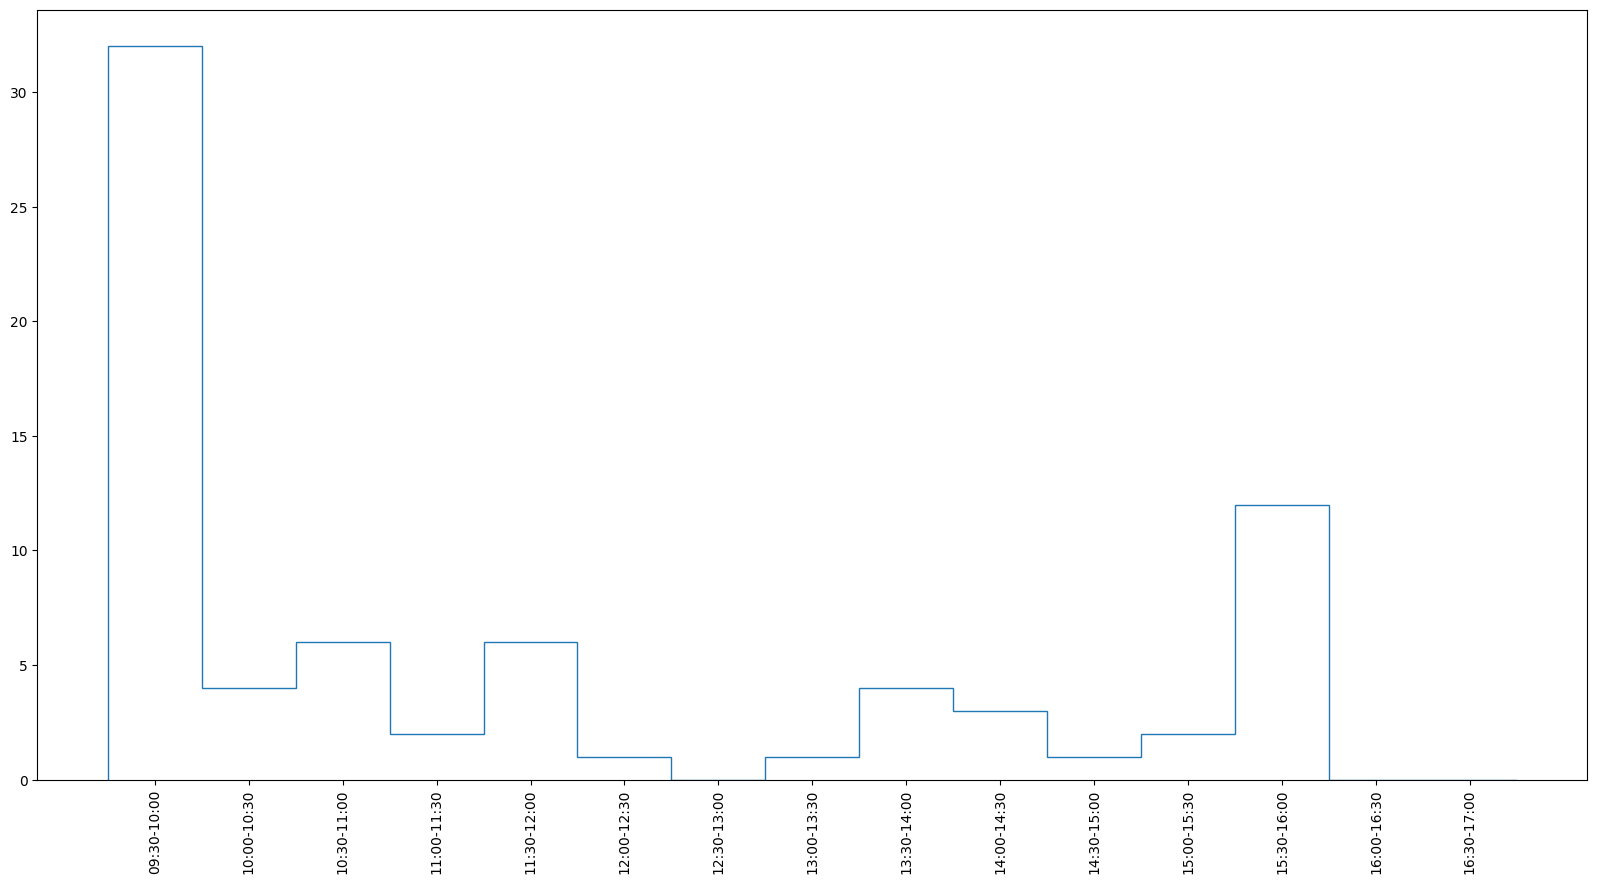

In [25]:
plt.figure(figsize=(20,10))
plt.xticks(locs,labels)
plt.xticks(rotation=90)
plt.stairs(list(df_hist_h['count']),edges=edges)

and then for the lows. 

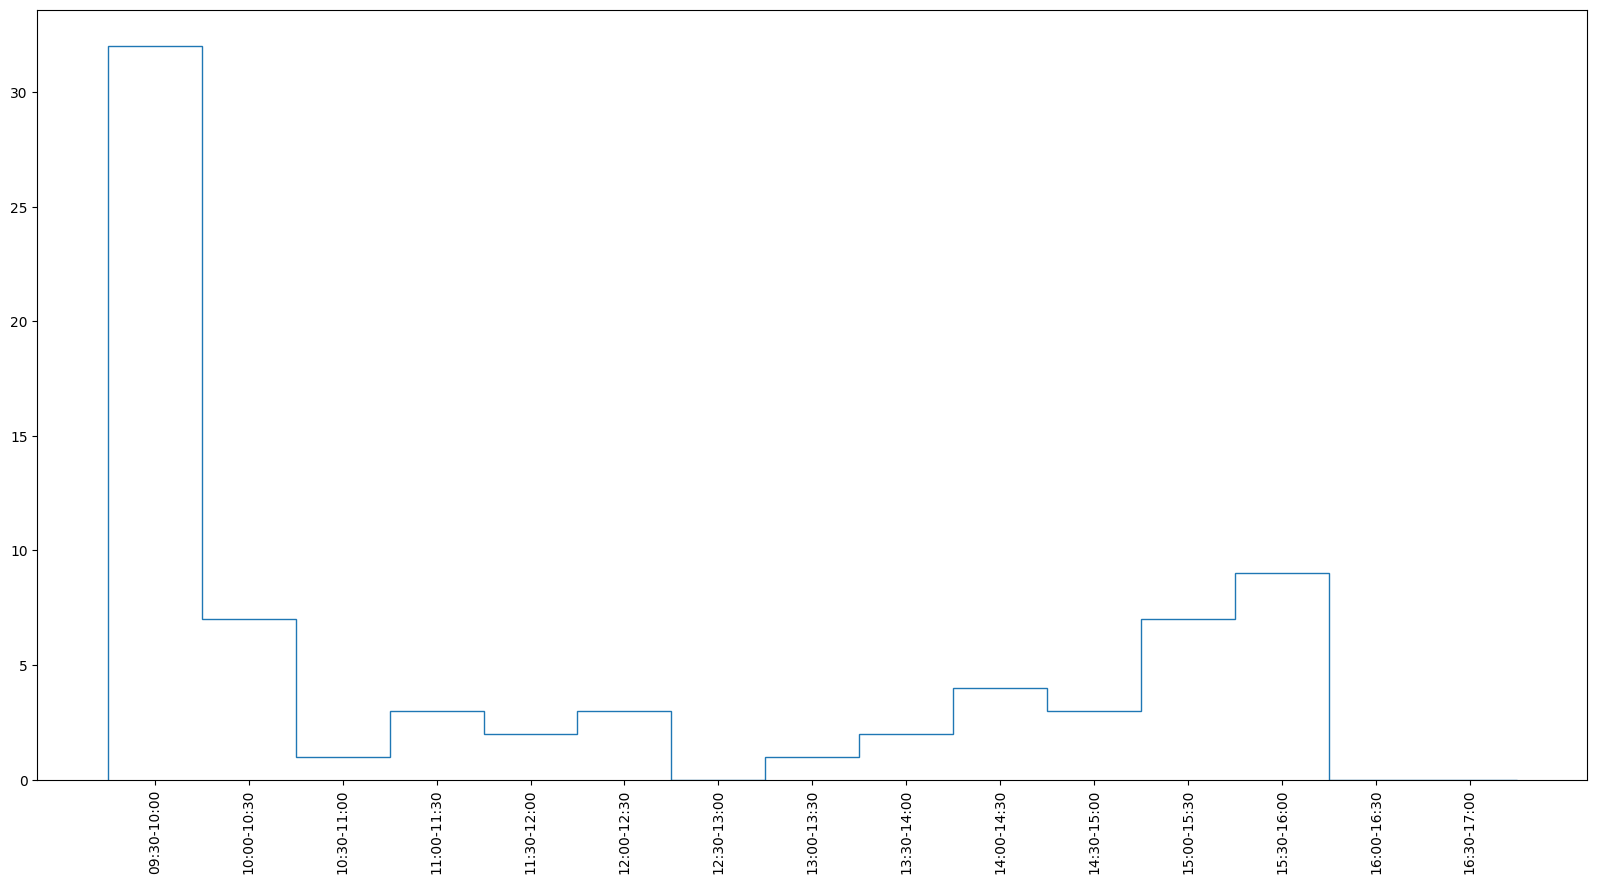

In [26]:
plt.figure(figsize=(20,10))
plt.xticks(locs,labels)
plt.xticks(rotation=90)
plt.stairs(list(df_hist_l['count']),edges=edges)

The original observation was correct, but it doesn't seem AGL specific nor do I know how actionable this phenomenon is. 